In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

#from keras.models import Sequential
#from keras.layers import LSTM, Dense, Input, Dropout
#from keras.models import Model

#from tensorflow import tf

from astral import LocationInfo
from astral import zoneinfo
from astral.sun import sun
import datetime


In [46]:
States = ['COLORADO', 'KANSAS', 'MINNESOTA', 'MONTANA', 'NEBRASKA', 'NORTH DAKOTA', 'OKLAHOMA', 'SOUTH DAKOTA', 'TEXAS']
Latitudes = [38.859826, 38.483388, 45.929065, 47.015361, 41.493332, 47.462360, 35.534694, 44.441550, 32.345252]
Longitudes = [-103.382157, -100.578638, -95.148739, -107.853316, -97.203989, -99.893032, -98.226251, -99.871998, -100.698788]

In [47]:
Month_days = [-1, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

def _is_leap(year):
    "year -> 1 if leap year, else 0."
    return year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)

def _days_in_month(year, month):
    assert 1 <= month <= 12, month
    if month == 2 and _is_leap(year):
        return 29
    return Month_days[month]

In [48]:
import pandas as pd
import openpyxl

col1 = "State"
col2 = "Year"
col3 = "Month"
col4 = "Total_Suntime"
monthly_suntime = [[],[],[],[]]

## 九個地區
for p in range(0, 9):
    city = LocationInfo(States[p], "US", " ", Latitudes[p], Longitudes[p])
    total = datetime.timedelta() ## 月資料

    ## 2023年
    for i in range(1, 13):
        ## 每月的天數
        for j in range(1, _days_in_month(2023, i)+1):
            day_now = datetime.date(2023, i, j)
            
            ## 如果資料有問題就用前後兩天插值
            try:
                Sunduration = sun(city.observer, date = day_now)
                delta = Sunduration["sunset"] - Sunduration["sunrise"]
            except:
                BSunduration = sun(city.observer, date = day_now - datetime.timedelta(1))
                BD = BSunduration["sunset"] - BSunduration["sunrise"]
                ASunduration = sun(city.observer, date = day_now + datetime.timedelta(1))
                AD = ASunduration["sunset"] - ASunduration["sunrise"]
                if BD < datetime.timedelta(0):
                    BD += datetime.timedelta(1)
                if AD < datetime.timedelta(0):
                    AD += datetime.timedelta(1)
                delta = (BD + AD) / 2
            if delta < datetime.timedelta(0):
                delta += datetime.timedelta(1)
            total += delta
            
        ## 加總整個月的日照秒數
        totalSecond = total.days * 86400 + total.seconds
        if total.microseconds >= 500000:
            totalSecond += 1
        monthly_suntime[0].append(city.name)
        monthly_suntime[1].append(2023)
        monthly_suntime[2].append(i)
        monthly_suntime[3].append(totalSecond)
        total = datetime.timedelta()

SunTime_Data = pd.DataFrame({col1:monthly_suntime[0],col2:monthly_suntime[1],col3:monthly_suntime[2],col4:monthly_suntime[3]})
## data.to_excel('SuntimeData.xlsx', sheet_name='Suntime', index=False)

In [49]:
SunTime_Data

,State,Year,Month,Total_Suntime
0,COLORADO,2023,1,1092664
1,COLORADO,2023,2,1081643
2,COLORADO,2023,3,1332811
3,COLORADO,2023,4,1426559
4,COLORADO,2023,5,1593799
...,...,...,...,...
103,TEXAS,2023,8,1485911
104,TEXAS,2023,9,1336163
105,TEXAS,2023,10,1269835
106,TEXAS,2023,11,1134410


In [50]:
SunTime_Data.to_excel('SuntimeData2023.xlsx', sheet_name = 'Suntime', index = False)

In [51]:
all = pd.read_csv("temp_adj.csv")
#future = pd.read_csv("X of 2023.csv")
#future

future = pd.read_csv("temp_2023.csv")
X_future = future[['Anomaly','Maximun Temperature','Anomaly.1','Anomaly.2','Average Temperature_x','encode_state','Year','Month','Minimum Temperature']]



{'n_estimators': 400, 'max_depth': None, 'max_learning_rate': [0.1, 0.3, 0.5]} best_mse 0.8661284642723563 10.665103222234496 best_ratio 10 best_r_2 0.9723880181745408
[03:30:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "max_learning_rate" } are not used.



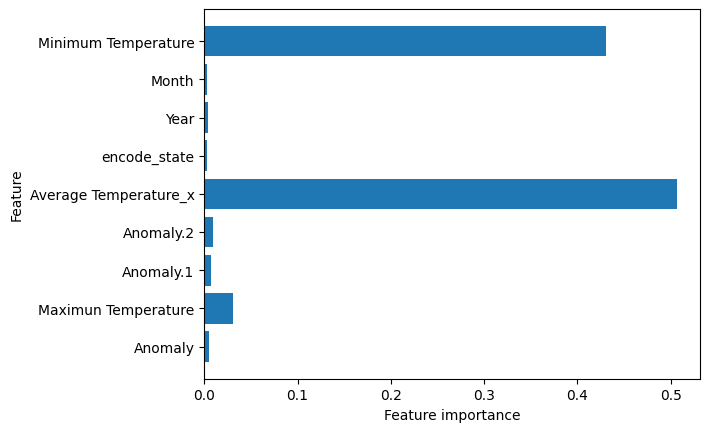

In [52]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error ,r2_score


X = all[['Anomaly','Maximun Temperature','Anomaly.1','Anomaly.2','Average Temperature_x','encode_state','Year','Month','Minimum Temperature']]
y = all['Average Temperature_y']
dic = {0:'COLORADO',
 1:'KANSAS',
 2:'MINNESOTA',
 3:'MONTANA',
 4:'NEBRASKA',
 5:'NORTH DAKOTA',
 6:'OKLAHOMA',
 7:'SOUTH DAKOTA',
 8:'TEXAS'}



n_estimators = [400]  # Number of trees
max_depth = [None]


best_mse = float('inf')
best_params = {}


for ratio in range(10,100,10):
    for estimators in n_estimators:
        for depth in max_depth:
            for rate in learning_rate:
            
                X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(ratio/100), random_state=71)
                # 初始化回歸器並設定參數

                params = {
                    'learning_rate': rate,  # 調整的第一個參數
                    'n_estimators': estimators,
                    'max_depth': depth,  # 調整的第二個參數
                    'random_state': 71
                }

                regressor = xgb.XGBRegressor(**params)
                
                # 訓練模型
                regressor.fit(X_train, y_train)
                
                # 預測測試集
                y_pred = regressor.predict(X_test)
                y_pred_train = regressor.predict(X_train)

                
               # 計算均方誤差 
                train_mse = mean_squared_error(y_pred_train, y_train)
                
                mse = mean_squared_error(y_test, y_pred)
                r_2= r2_score(y_test, y_pred)
                # 如果得到更好的結果，則更新最佳參數和最佳均方誤差
                if mse < best_mse:
                    best_mse = mse
                    best_r_2 = r_2
                    best_mse_train = train_mse
                    best_params = {
                        
                        'n_estimators': estimators,
                        'max_depth': depth,
                        'max_learning_rate': learning_rate
                    }
                    best_ratio = ratio

print(best_params,'best_mse',best_mse_train,best_mse,'best_ratio',best_ratio,'best_r_2',best_r_2)



regressor = xgb.XGBRegressor(**best_params)
            
# 訓練模型
regressor.fit(X_train, y_train)

y_Fpred = regressor.predict(X_future)

# 計算均方誤差
#mse = mean_squared_error(y_future, y_Fpred)


#print('Precipitatio_mse',mse)

def plot_feature_importances(model):
    n_features = ['Anomaly','Maximun Temperature','Anomaly.1','Anomaly.2','Average Temperature_x','encode_state','Year','Month','Minimum Temperature']
    plt.barh(n_features, model.feature_importances_, align='center')
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.show()


plot_feature_importances(regressor)

data_list = y_Fpred.tolist()

data = np.zeros((len(data_list),4))

for i in range(len(data_list)):
    data[i,0] = data_list[i]

for i in range(len(data_list)):
    data[i,1] = future['encode_state'][i]

for i in range(len(data_list)):
    data[i,2] = future['Year'][i]

for i in range(len(data_list)):
    data[i,3] = future['Month'][i]




columns = ['forecast','encode_state','Year','Month']
temp_result = pd.DataFrame(columns=columns, data=data)
#result.to_csv('forecast_XGboost.csv',encoding = 'gbk')



In [53]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [54]:
all = pd.read_csv("all state precipitation.csv")
future = pd.read_csv("X of 2023.csv")
future

,Year,Month,PastTemperature,PastPrecipitation,Encode
0,2023,1,26.6,0.78,0
1,2023,2,25.0,0.94,0
2,2023,3,35.0,1.44,0
3,2023,4,43.7,0.73,0
4,2023,5,53.3,1.60,0
...,...,...,...,...,...
103,2023,8,83.3,4.33,8
104,2023,9,77.8,1.41,8
105,2023,10,66.4,2.36,8
106,2023,11,54.0,2.73,8


In [55]:
X = all[['Month', 'PastTemperature', 'PastPrecipitation', 'Encode']]
y = all['Precipitation']
dic = {0:'COLORADO',
 1:'KANSAS',
 2:'MINNESOTA',
 3:'MONTANA',
 4:'NEBRASKA',
 5:'NORTH DAKOTA',
 6:'OKLAHOMA',
 7:'SOUTH DAKOTA',
 8:'TEXAS'}

#最佳比例
position = int(len(X) * 50 / 100)
X_train = X[:position]
y_train = y[:position]

#最佳參數
random_forest = RandomForestRegressor(n_estimators=50, max_depth=11, min_samples_leaf=1)

#訓練
random_forest.fit(X_train, y_train)

#預測
precipitation_list = []
for i in range(108):
    X =[[future["Month"][i], future["PastTemperature"][i], future["PastPrecipitation"][i], future["Encode"][i]]]
    precipitation_list.append([future["Month"][i], dic[future["Encode"][i]], float(random_forest.predict(X))])


#轉成csv
columns = ['Month', 'State', 'Precipitation']
Precipitation_result = pd.DataFrame(columns=columns, data=precipitation_list)


c:\Users\JOU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\JOU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\JOU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\JOU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\JOU\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but

In [58]:
data = np.zeros((len(data_list),6))
for i in range(108):

    data[i,0] = temp_result['Year'][i]
    data[i,1] = temp_result['Month'][i]
    data[i,2] = temp_result['encode_state'][i]
    data[i,3] = temp_result['forecast'][i]
    data[i,4] = Precipitation_result['Precipitation'][i]
    data[i,5] = SunTime_Data['Total_Suntime'][i]





columns = ['Year','Month','encode_state','forecast','Precipitation','Total_Suntime']
all_result = pd.DataFrame(columns=columns, data=data)
all_result.to_csv('all_result.csv',encoding = 'gbk')